**Лабораторная работа № 2**

Реализовать с помощью Numpy класс MyMLP, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен:
*   Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
*   Обеспечивать выбор следующих функции активации в рамках каждого слоя: ReLU, sigmoid, linear.
*   Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
*   В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
Поддерживать использование l1, l2 и l1l2 регуляризаций.

Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций) и сравнить результаты работы (оценка качества модели + время обучения и инференса) реализованного класса MyMLP со следующими моделям (в одинаковых конфигурациях):
*   MLPClassifier/MLPRegressor из sklearn
*   TensorFlow
*   Keras
*   PyTorch
Результат представить в виде .ipynb блокнота, содержащего весь необходимый код и визуализации сравнения реализаций для рассмотренных конфигураций.

## Часть 1

In [1]:
import numpy as np

class MyMLP:
    def __init__(self, layer_sizes, activations, loss="mse", regularization=None, reg_lambda=0.01):
        self.layers = len(layer_sizes) - 1
        self.activations_names = activations
        self.loss_name = loss
        self.reg_name = regularization
        self.reg_lambda = reg_lambda

        self.weights = [np.random.randn(n_in, n_out) * 0.1 for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, n)) for n in layer_sizes[1:]]

        self._init_functions()

    def _init_functions(self):
        # Активационные функции и производные
        self.activation_funcs = {
            "relu": (lambda x: np.maximum(0, x), lambda x: (x > 0).astype(float)),
            "sigmoid": (lambda x: 1 / (1 + np.exp(-x)), lambda x: (1 / (1 + np.exp(-x))) * (1 - (1 / (1 + np.exp(-x))))),
            "linear": (lambda x: x, lambda x: np.ones_like(x)),
        }

        # Функции потерь и их производные
        self.loss_funcs = {
            "mse": (
                lambda y_true, y_pred: np.mean((y_true - y_pred) ** 2),
                lambda y_true, y_pred: (y_pred - y_true) / y_true.shape[0]
            ),
            "cross_entropy": (
                lambda y_true, y_pred: -np.mean(np.sum(y_true * np.log(np.clip(y_pred, 1e-12, 1 - 1e-12)), axis=1)),
                lambda y_true, y_pred: (y_pred - y_true) / y_true.shape[0]
            )
        }

        # Регуляризации и производные
        self.reg_funcs = {
            "l1": (
                lambda w: np.sum(np.abs(w)),
                lambda w: np.sign(w)
            ),
            "l2": (
                lambda w: np.sum(w ** 2),
                lambda w: 2 * w
            ),
            "l1l2": (
                lambda w: np.sum(np.abs(w)) + np.sum(w ** 2),
                lambda w: np.sign(w) + 2 * w
            ),
            None: (
                lambda w: 0,
                lambda w: 0
            )
        }

    def _forward(self, x):
        self.z = []
        self.a = [x]
        for i in range(self.layers):
            z = self.a[-1] @ self.weights[i] + self.biases[i]
            act_func = self.activation_funcs[self.activations_names[i]][0]
            a = act_func(z)
            self.z.append(z)
            self.a.append(a)
        return self.a[-1]

    def _backward(self, y_true, lr):
        loss_grad = self.loss_funcs[self.loss_name][1]
        delta = loss_grad(y_true, self.a[-1]) * self.activation_funcs[self.activations_names[-1]][1](self.z[-1])

        for i in reversed(range(self.layers)):
            reg_grad_func = self.reg_funcs[self.reg_name][1]
            grad_w = self.a[i].T @ delta + self.reg_lambda * reg_grad_func(self.weights[i])
            grad_b = np.sum(delta, axis=0, keepdims=True)

            self.weights[i] -= lr * grad_w
            self.biases[i] -= lr * grad_b

            if i > 0:
                delta = (delta @ self.weights[i].T) * self.activation_funcs[self.activations_names[i - 1]][1](self.z[i - 1])

    def fit(self, X, y, epochs=100, batch_size=32, lr=0.01, verbose=True):
        n = X.shape[0]
        loss_func = self.loss_funcs[self.loss_name][0]
        reg_func = self.reg_funcs[self.reg_name][0]

        for epoch in range(epochs):
            indices = np.random.permutation(n)
            X_shuffled, y_shuffled = X[indices], y[indices]
            for i in range(0, n, batch_size):
                x_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                self._forward(x_batch)
                self._backward(y_batch, lr)

            if verbose and epoch % 10 == 0:
                y_pred = self._forward(X)
                loss = loss_func(y, y_pred)
                reg_loss = sum(reg_func(w) for w in self.weights)
                total_loss = loss + self.reg_lambda * reg_loss
                print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    def predict(self, X):
        return self._forward(X)

In [2]:
# тест
X = np.array([1,2,3,4]).reshape(-1, 1)
y = np.array([2,4,9,16]).reshape(-1, 1)

mlp = MyMLP(layer_sizes=[1, 4, 1], activations=['relu', 'relu'], loss='mse', regularization='l2', reg_lambda=0.01)
mlp.fit(X, y, epochs=2000, lr=0.005)
print("Predictions:\n", mlp.predict(X))

Epoch 0, Loss: 89.2505
Epoch 10, Loss: 89.2505
Epoch 20, Loss: 89.2505
Epoch 30, Loss: 89.2505
Epoch 40, Loss: 89.2505
Epoch 50, Loss: 89.2505
Epoch 60, Loss: 89.2505
Epoch 70, Loss: 89.2505
Epoch 80, Loss: 89.2505
Epoch 90, Loss: 89.2505
Epoch 100, Loss: 89.2505
Epoch 110, Loss: 89.2505
Epoch 120, Loss: 89.2505
Epoch 130, Loss: 89.2505
Epoch 140, Loss: 89.2505
Epoch 150, Loss: 89.2505
Epoch 160, Loss: 89.2505
Epoch 170, Loss: 89.2505
Epoch 180, Loss: 89.2505
Epoch 190, Loss: 89.2505
Epoch 200, Loss: 89.2505
Epoch 210, Loss: 89.2505
Epoch 220, Loss: 89.2505
Epoch 230, Loss: 89.2505
Epoch 240, Loss: 89.2505
Epoch 250, Loss: 89.2505
Epoch 260, Loss: 89.2505
Epoch 270, Loss: 89.2505
Epoch 280, Loss: 89.2505
Epoch 290, Loss: 89.2505
Epoch 300, Loss: 89.2505
Epoch 310, Loss: 89.2505
Epoch 320, Loss: 89.2505
Epoch 330, Loss: 89.2505
Epoch 340, Loss: 89.2505
Epoch 350, Loss: 89.2505
Epoch 360, Loss: 89.2505
Epoch 370, Loss: 89.2505
Epoch 380, Loss: 89.2505
Epoch 390, Loss: 89.2505
Epoch 400, 

## Часть 2

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import time
import tensorflow as tf

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import warnings
warnings.filterwarnings('ignore')

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

In [5]:
# Предобработка данных
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)

## Skikit-Learn

In [6]:
# Skikit-Learn
def train_sklearn_mlp(hidden_layers, activation, learning_rate, max_iter=10):
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver='adam',
        learning_rate_init=learning_rate,
        max_iter=max_iter,
        batch_size=64,
        random_state=42
    )

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Инференс
    start_inf = time.time()
    y_pred = model.predict(X_test)
    inf_time = (time.time() - start_inf) / len(X_test) * 1000

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, train_time, inf_time

## TensorFlow

In [7]:
def train_tensorflow_mlp(hidden_layers, activation, learning_rate, epochs=10):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(784,)))

    for units in hidden_layers:
        model.add(tf.keras.layers.Dense(units, activation=activation))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=epochs,
        verbose=0
    )
    train_time = time.time() - start_time

    # Инференс
    start_inf = time.time()
    y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
    inf_time = (time.time() - start_inf) / len(X_test) * 1000

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, train_time, inf_time

## Keras

In [8]:
def train_keras_mlp(hidden_layers, activation, learning_rate, epochs=10):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation=activation, input_shape=(784,)))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))

    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=epochs,
        verbose=0
    )
    train_time = time.time() - start_time

    # Инференс
    start_inf = time.time()
    y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
    inf_time = (time.time() - start_inf) / len(X_test) * 1000  # мс на образец

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, train_time, inf_time

## PyTorch

In [9]:
class PyTorchMLP(nn.Module):
    def __init__(self, hidden_layers, activation):
        super(PyTorchMLP, self).__init__()
        layers = []
        input_size = 784

        for units in hidden_layers:
            layers.append(nn.Linear(input_size, units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            input_size = units

        layers.append(nn.Linear(input_size, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_pytorch_mlp(hidden_layers, activation, learning_rate, epochs=10):
    # Преобразование данных в тензоры PyTorch
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)

    # Создание DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Инициализация модели
    model = PyTorchMLP(hidden_layers, activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Обучение
    start_time = time.time()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    train_time = time.time() - start_time

    # Инференс
    model.eval()
    start_inf = time.time()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)
    inf_time = (time.time() - start_inf) / len(X_test) * 1000

    accuracy = accuracy_score(y_test, y_pred.numpy())

    return accuracy, train_time, inf_time

## MyMLP

In [10]:
import numpy as np

class MyMLP:
    def __init__(self, layer_sizes, activations, loss="mse", regularization=None, reg_lambda=0.01):
        self.layers = len(layer_sizes) - 1
        self.activations_names = activations
        self.loss_name = loss
        self.reg_name = regularization
        self.reg_lambda = reg_lambda

        self.weights = [np.random.randn(n_in, n_out) * 0.1 for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, n)) for n in layer_sizes[1:]]

        self._init_functions()

    def _init_functions(self):
        # Активационные функции и производные
        self.activation_funcs = {
            "relu": (lambda x: np.maximum(0, x), lambda x: (x > 0).astype(float)),
            "sigmoid": (lambda x: 1 / (1 + np.exp(-x)), lambda x: (1 / (1 + np.exp(-x))) * (1 - (1 / (1 + np.exp(-x))))),
            "linear": (lambda x: x, lambda x: np.ones_like(x)),
        }

        # Функции потерь и их производные
        self.loss_funcs = {
            "mse": (
                lambda y_true, y_pred: np.mean((y_true - y_pred) ** 2),
                lambda y_true, y_pred: (y_pred - y_true) / y_true.shape[0]
            ),
            "cross_entropy": (
                lambda y_true, y_pred: -np.mean(np.sum(y_true * np.log(np.clip(y_pred, 1e-12, 1 - 1e-12)), axis=1)),
                lambda y_true, y_pred: (y_pred - y_true) / y_true.shape[0]
            )
        }

        # Регуляризации и производные
        self.reg_funcs = {
            "l1": (
                lambda w: np.sum(np.abs(w)),
                lambda w: np.sign(w)
            ),
            "l2": (
                lambda w: np.sum(w ** 2),
                lambda w: 2 * w
            ),
            "l1l2": (
                lambda w: np.sum(np.abs(w)) + np.sum(w ** 2),
                lambda w: np.sign(w) + 2 * w
            ),
            None: (
                lambda w: 0,
                lambda w: 0
            )
        }

    def _forward(self, x):
        self.z = []
        self.a = [x]
        for i in range(self.layers):
            z = self.a[-1] @ self.weights[i] + self.biases[i]
            act_func = self.activation_funcs[self.activations_names[i]][0]
            a = act_func(z)
            self.z.append(z)
            self.a.append(a)
        return self.a[-1]

    def _backward(self, y_true, lr):
        loss_grad = self.loss_funcs[self.loss_name][1]
        delta = loss_grad(y_true, self.a[-1]) * self.activation_funcs[self.activations_names[-1]][1](self.z[-1])

        for i in reversed(range(self.layers)):
            reg_grad_func = self.reg_funcs[self.reg_name][1]
            grad_w = self.a[i].T @ delta + self.reg_lambda * reg_grad_func(self.weights[i])
            grad_b = np.sum(delta, axis=0, keepdims=True)

            self.weights[i] -= lr * grad_w
            self.biases[i] -= lr * grad_b

            if i > 0:
                delta = (delta @ self.weights[i].T) * self.activation_funcs[self.activations_names[i - 1]][1](self.z[i - 1])

    def fit(self, X, y, epochs=100, batch_size=32, lr=0.01, verbose=True):
        n = X.shape[0]
        loss_func = self.loss_funcs[self.loss_name][0]
        reg_func = self.reg_funcs[self.reg_name][0]

        for epoch in range(epochs):
            indices = np.random.permutation(n)
            X_shuffled, y_shuffled = X[indices], y[indices]
            for i in range(0, n, batch_size):
                x_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                self._forward(x_batch)
                self._backward(y_batch, lr)

            if verbose and epoch % 10 == 0:
                y_pred = self._forward(X)
                loss = loss_func(y, y_pred)
                reg_loss = sum(reg_func(w) for w in self.weights)
                total_loss = loss + self.reg_lambda * reg_loss
                print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    def predict(self, X):
        return self._forward(X)

def train_mymlp_mlp(hidden_layers, activation, learning_rate, epochs=10):

    layer_sizes = [784] + list(hidden_layers) + [10]

    # Преобразуем названия активаций для MyMLP
    activations = [activation] * len(hidden_layers) + ['linear']  # выходной слой без активации


    model = MyMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        loss="cross_entropy",
        regularization="l2",
        reg_lambda=0.01
    )

    # Преобразуем y в one-hot encoding для cross_entropy
    y_train_onehot = np.eye(10)[y_train]

    # Обучение
    start_time = time.time()
    model.fit(
        X_train, y_train_onehot,
        epochs=epochs,
        batch_size=64,
        lr=learning_rate,
        verbose=False
    )
    train_time = time.time() - start_time

    # Инференс
    start_inf = time.time()
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    inf_time = (time.time() - start_inf) / len(X_test) * 1000

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, train_time, inf_time

# Эксперименты

In [11]:
configurations = [
    {'name': 'Config 1', 'hidden_layers': (128,), 'activation': 'relu', 'learning_rate': 0.001},
    {'name': 'Config 2', 'hidden_layers': (256, 128), 'activation': 'relu', 'learning_rate': 0.001},
]

In [12]:
results = {
    'sklearn': {'accuracy': [], 'train_time': [], 'inf_time': []},
    'tensorflow': {'accuracy': [], 'train_time': [], 'inf_time': []},
    'keras': {'accuracy': [], 'train_time': [], 'inf_time': []},
    'pytorch': {'accuracy': [], 'train_time': [], 'inf_time': []},
    'mymlp': {'accuracy': [], 'train_time': [], 'inf_time': []}
}

for config in configurations:
    print(f"\nTesting configuration: {config['name']}")

    # Scikit-learn
    print("Testing scikit-learn...")
    acc, t_time, inf_time = train_sklearn_mlp(
        config['hidden_layers'],
        config['activation'],
        config['learning_rate']
    )
    results['sklearn']['accuracy'].append(acc)
    results['sklearn']['train_time'].append(t_time)
    results['sklearn']['inf_time'].append(inf_time)

    # TensorFlow
    print("Testing TensorFlow...")
    acc, t_time, inf_time = train_tensorflow_mlp(
        config['hidden_layers'],
        config['activation'],
        config['learning_rate']
    )
    results['tensorflow']['accuracy'].append(acc)
    results['tensorflow']['train_time'].append(t_time)
    results['tensorflow']['inf_time'].append(inf_time)

    # Keras
    print("Testing Keras...")
    acc, t_time, inf_time = train_keras_mlp(
        config['hidden_layers'],
        config['activation'],
        config['learning_rate']
    )
    results['keras']['accuracy'].append(acc)
    results['keras']['train_time'].append(t_time)
    results['keras']['inf_time'].append(inf_time)

    # PyTorch
    print("Testing PyTorch...")
    acc, t_time, inf_time = train_pytorch_mlp(
        config['hidden_layers'],
        config['activation'],
        config['learning_rate']
    )
    results['pytorch']['accuracy'].append(acc)
    results['pytorch']['train_time'].append(t_time)
    results['pytorch']['inf_time'].append(inf_time)

    # MyMLP
    print("Testing MyMLP...")
    acc, t_time, inf_time = train_mymlp_mlp(
        config['hidden_layers'],
        config['activation'],
        config['learning_rate']
    )
    results['mymlp']['accuracy'].append(acc)
    results['mymlp']['train_time'].append(t_time)
    results['mymlp']['inf_time'].append(inf_time)


Testing configuration: Config 1
Testing scikit-learn...
Testing TensorFlow...
Testing Keras...
Testing PyTorch...
Testing MyMLP...

Testing configuration: Config 2
Testing scikit-learn...
Testing TensorFlow...
Testing Keras...
Testing PyTorch...
Testing MyMLP...


# Визуализация

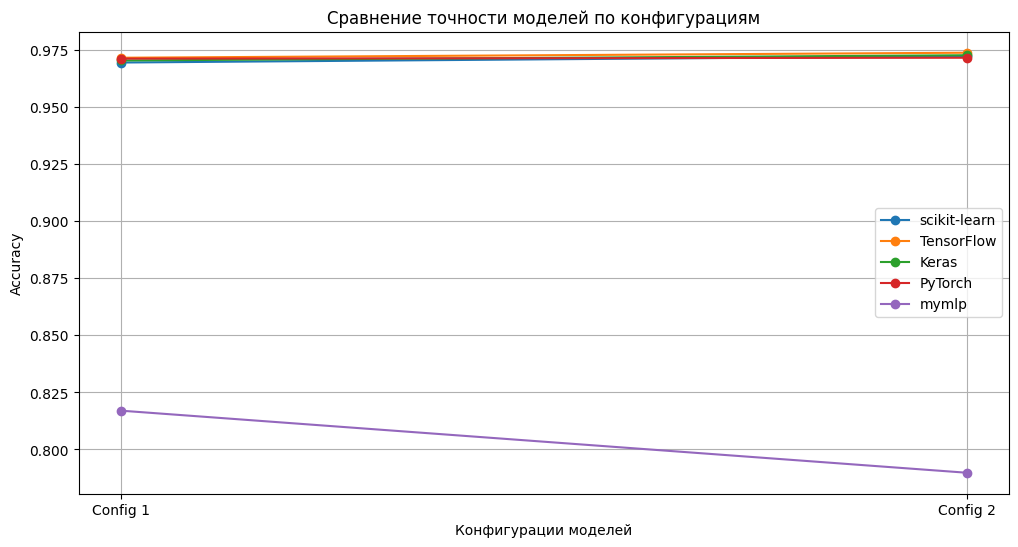

In [13]:
config_names = [config['name'] for config in configurations]

plt.figure(figsize=(12, 6))
plt.plot(config_names, results['sklearn']['accuracy'], 'o-', label='scikit-learn')
plt.plot(config_names, results['tensorflow']['accuracy'], 'o-', label='TensorFlow')
plt.plot(config_names, results['keras']['accuracy'], 'o-', label='Keras')
plt.plot(config_names, results['pytorch']['accuracy'], 'o-', label='PyTorch')
plt.plot(config_names, results['mymlp']['accuracy'], 'o-', label='mymlp')


plt.xlabel('Конфигурации моделей')
plt.ylabel('Accuracy')
plt.title('Сравнение точности моделей по конфигурациям')
plt.legend()
plt.grid(True)
plt.show()

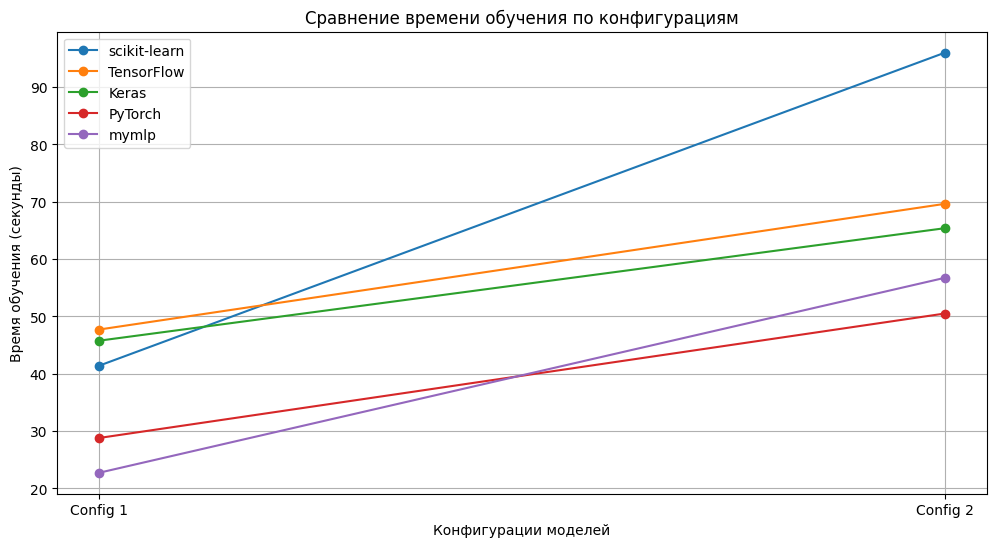

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(config_names, results['sklearn']['train_time'], 'o-', label='scikit-learn')
plt.plot(config_names, results['tensorflow']['train_time'], 'o-', label='TensorFlow')
plt.plot(config_names, results['keras']['train_time'], 'o-', label='Keras')
plt.plot(config_names, results['pytorch']['train_time'], 'o-', label='PyTorch')
plt.plot(config_names, results['mymlp']['train_time'], 'o-', label='mymlp')


plt.xlabel('Конфигурации моделей')
plt.ylabel('Время обучения (секунды)')
plt.title('Сравнение времени обучения по конфигурациям')
plt.legend()
plt.grid(True)
plt.show()

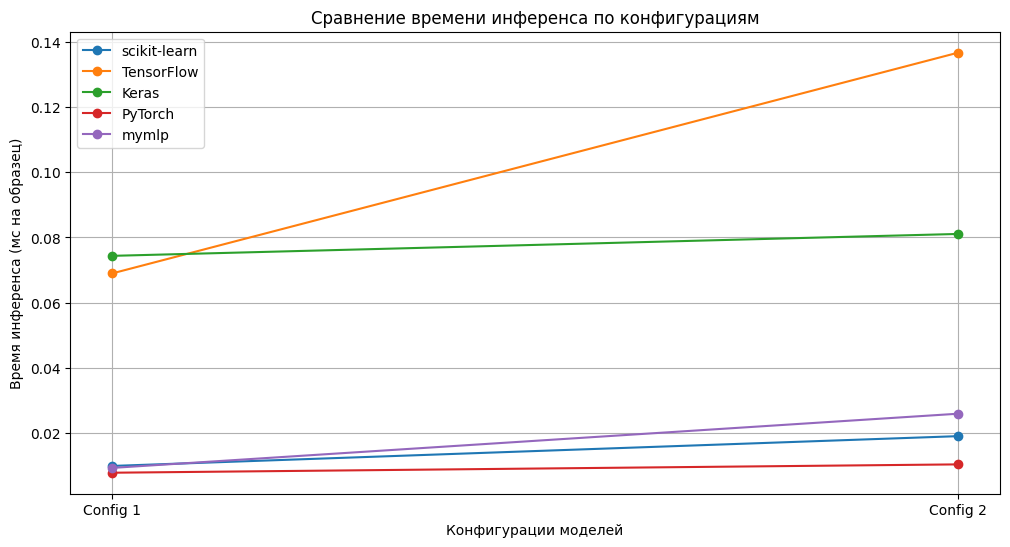

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(config_names, results['sklearn']['inf_time'], 'o-', label='scikit-learn')
plt.plot(config_names, results['tensorflow']['inf_time'], 'o-', label='TensorFlow')
plt.plot(config_names, results['keras']['inf_time'], 'o-', label='Keras')
plt.plot(config_names, results['pytorch']['inf_time'], 'o-', label='PyTorch')
plt.plot(config_names, results['mymlp']['inf_time'], 'o-', label='mymlp')


plt.xlabel('Конфигурации моделей')
plt.ylabel('Время инференса (мс на образец)')
plt.title('Сравнение времени инференса по конфигурациям')
plt.legend()
plt.grid(True)
plt.show()

--------------------------------------------------------------------------------

In [16]:
data = []
for i, config in enumerate(configurations):
    data.append({
        'Configuration': config['name'],
        'Framework': 'scikit-learn',
        'Accuracy': results['sklearn']['accuracy'][i],
        'Training Time (s)': results['sklearn']['train_time'][i],
        'Inference Time (ms)': results['sklearn']['inf_time'][i]
    })
    data.append({
        'Configuration': config['name'],
        'Framework': 'TensorFlow',
        'Accuracy': results['tensorflow']['accuracy'][i],
        'Training Time (s)': results['tensorflow']['train_time'][i],
        'Inference Time (ms)': results['tensorflow']['inf_time'][i]
    })
    data.append({
        'Configuration': config['name'],
        'Framework': 'Keras',
        'Accuracy': results['keras']['accuracy'][i],
        'Training Time (s)': results['keras']['train_time'][i],
        'Inference Time (ms)': results['keras']['inf_time'][i]
    })
    data.append({
        'Configuration': config['name'],
        'Framework': 'PyTorch',
        'Accuracy': results['pytorch']['accuracy'][i],
        'Training Time (s)': results['pytorch']['train_time'][i],
        'Inference Time (ms)': results['pytorch']['inf_time'][i]
    })
    data.append({
        'Configuration': config['name'],
        'Framework': 'MyMLP',
        'Accuracy': results['mymlp']['accuracy'][i],
        'Training Time (s)': results['mymlp']['train_time'][i],
        'Inference Time (ms)': results['mymlp']['inf_time'][i]
    })

df_results = pd.DataFrame(data)
df_results

,Configuration,Framework,Accuracy,Training Time (s),Inference Time (ms)
0,Config 1,scikit-learn,0.9696,41.417450,0.009860
1,Config 1,TensorFlow,0.9717,47.716079,0.068985
2,Config 1,Keras,0.9705,45.771617,0.074360
3,Config 1,PyTorch,0.9713,28.810523,0.007777
4,Config 1,MyMLP,0.8170,22.747167,0.009258
5,Config 2,scikit-learn,0.9724,95.975935,0.019002
6,Config 2,TensorFlow,0.9739,69.626018,0.136718
7,Config 2,Keras,0.9728,65.377517,0.081079
8,Config 2,PyTorch,0.9717,50.502474,0.010336
9,Config 2,MyMLP,0.7898,56.725790,0.025888
